## Import Libraries

In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pwd

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pwd: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [44]:
import os
os.chdir('/content/drive/My Drive/gc2ae/SN_keras/')
!ls

CBN.py				    model.py
CIFAR10-ResNet-CrammerSinger.ipynb  models
CIFAR10-ResNet.ipynb		    __pycache__
data_utils.py			    pyimagesearch
GC2AE-CrammerSinger-FM.ipynb	    ResNet-CrammerSinger-FM.ipynb
GC2AE-CS-FM_Reconstruct.ipynb	    SpectralNormalizationKeras.py
img				    test_GC2AE.ipynb
losses				    train_Classifier.ipynb


In [45]:
!pip install keras==2.1.5
%tensorflow_version 1.x
import keras
keras.__version__

'2.1.5'

In [46]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [47]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
%matplotlib inline

from model import *

from keras.optimizers import Adam
from keras.datasets import mnist,cifar10,cifar100

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,\
                            LearningRateScheduler,CSVLogger,LambdaCallback

from data_utils import onehotencode,sample_known_unknown_classes,get_mapped_labels

from pyimagesearch.learningratefinder import LearningRateFinder
from pyimagesearch.clr_callback import CyclicLR

import numpy as np
import matplotlib.pyplot as plt
import joblib

import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

In [49]:
LATENT_DIM = 128

DS = 'MNIST' #CIFAR10 SVHN TIN

IMG_SHAPE = (28,28,1)
NUM_CLASSES = 10

if DS == 'CIFAR10':
    IMG_SHAPE = (32,32,3)

'''
elif DS == 'SVHN':
    IN_SHAPE = SVHN_SHAPE
    CBN = SVHN_NCLASSES
elif DS == 'TIN':
    IN_SHAPE = TIN_SHAPE
    CBN = TIN_NCLASSES
'''



"\nelif DS == 'SVHN':\n    IN_SHAPE = SVHN_SHAPE\n    CBN = SVHN_NCLASSES\nelif DS == 'TIN':\n    IN_SHAPE = TIN_SHAPE\n    CBN = TIN_NCLASSES\n"

In [50]:
if DS == 'MNIST':
    dataset = mnist
elif DS == 'CIFAR10':
    dataset = cifar10
    
'''    
elif DS == 'SVHN':
    IN_SHAPE = SVHN_SHAPE
    CBN = SVHN_NCLASSES
elif DS == 'TIN':
    IN_SHAPE = TIN_SHAPE
    CBN = TIN_NCLASSES
'''

"    \nelif DS == 'SVHN':\n    IN_SHAPE = SVHN_SHAPE\n    CBN = SVHN_NCLASSES\nelif DS == 'TIN':\n    IN_SHAPE = TIN_SHAPE\n    CBN = TIN_NCLASSES\n"

In [0]:
def auroc(y_true, y_pred):
    try:
        return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    except:
        return -1

## Configure Known Unknown Classes

In [0]:
#_,known_classes,unknown_classes = sample_known_unknown_classes(10,6)

known_classes = [9, 6, 0, 5, 3, 7]
unknown_classes = [8, 1, 2, 4]

known_class_mapping = {}
known_class_mapping_inv = {}
i=0
for kc in known_classes:
    known_class_mapping[kc] = i
    known_class_mapping_inv[i] = kc
    i+=1

In [53]:
print(known_classes)
print(unknown_classes)

[9, 6, 0, 5, 3, 7]
[8, 1, 2, 4]


## Train Classifier

In [13]:
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = (x_train - 127.5)/127.5
x_test = (x_test - 127.5)/127.5

#Configure Training Data
y_train_known = y_train[np.where(np.isin(y_train,known_classes))]
#y_train_unknown = y_train[np.where(np.isin(y_train,unknown_classes))]

x_train_known = x_train[np.where(np.isin(y_train,known_classes))]
#x_train_unknown = x_train[np.where(np.isin(y_train,unknown_classes))]

y_test_known = y_test[np.where(np.isin(y_test,known_classes))]
x_test_known = x_test[np.where(np.isin(y_test,known_classes))]

y_train_known_mapped = get_mapped_labels(y_train_known,known_class_mapping)
y_test_known_mapped = get_mapped_labels(y_test_known,known_class_mapping)

y_train_ohe = onehotencode(y_train_known_mapped,wgan=False)
y_test_ohe = onehotencode(y_test_known_mapped,wgan=False)

if len(x_train_known.shape)<4:
    x_train_known = np.expand_dims(x_train_known,axis=-1)
    x_test_known = np.expand_dims(x_test_known,axis=-1)
    
del x_train, y_train, x_test, y_test

x_train, x_val, y_train, y_val = train_test_split(x_train_known,y_train_ohe,
                                                  test_size=0.1,random_state=10)

11493376/11490434 [==============================] - 1s 0us/step


In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test_known.shape)
print(y_test_ohe.shape)
#print(y_test_unknown.shape)

(32046, 28, 28, 1)
(32046, 6)
(3561, 28, 28, 1)
(3561, 6)
(5877, 28, 28, 1)
(5877, 6)


In [15]:
print(y_train_known_mapped[:5])
print(y_train_ohe[:5])

[3 2 0 4 4]
[[0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


[0 0 0 0 1 0]
4
3


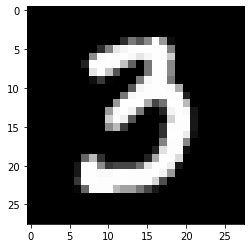

In [16]:
idx = 1000
print(y_train[idx])
print(np.argmax(y_train[idx]))
print(known_class_mapping_inv[ np.argmax(y_train[idx]) ])
plt.imshow(x_train[idx,:,:,0],cmap='gray')

0


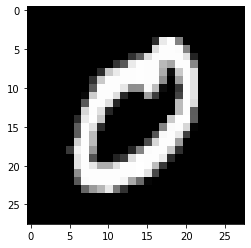

In [0]:
idx = 9492
print( known_class_mapping_inv[y_train_known_mapped[idx]] )
plt.imshow(x_train_known[idx,:,:,0],cmap='gray')

In [0]:
encoder = BuildEncoder(in_shape=IMG_SHAPE, latent_dim=LATENT_DIM)







Encoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Discriminator_resblock_Down_ (None, 14, 14, 128)       149636    
_________________________________________________________________
Discriminator_resblock_Down_ (None, 7, 7, 128)         312704    
_________________________________________________________________
Discriminator_resblock_1 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
Discriminator_resblock_2 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_sum_pooling2d_1 (Glob (None, 128)               0      

In [0]:
classifier = BuildClassifier(encoder=encoder,in_shape=IMG_SHAPE,
                             num_classes=len(known_classes))

Classifier
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder_Encoder (Model)      (None, 128)               1054724   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,055,498
Trainable params: 1,053,704
Non-trainable params: 1,794
_________________________________________________________________


In [0]:
nsamples = x_train.shape[0]
batch_size = 128

In [0]:
classifier.compile(optimizer=Adam(0.001),loss='categorical_crossentropy')

In [0]:
lrf = LearningRateFinder(classifier)
lrf.find(
    trainData=[x_train,y_train],
    startLR=1e-8, endLR=1e-1,
    useGen=False,
    epochs=5,
    stepsPerEpoch=np.ceil((nsamples/float(batch_size))),
    batchSize=batch_size,
    verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
32046/32046 [==============================] - 24s 752us/step - loss: 12.6720
Epoch 2/5
32046/32046 [==============================] - 16s 502us/step - loss: 9.2354
Epoch 3/5
32046/32046 [==============================] - 16s 501us/step - loss: 3.5581
Epoch 4/5
32046/32046 [==============================] - 16s 500us/step - loss: 6.1302
Epoch 5/5
23680/32046 [=====================>........] - ETA: 4s - loss: 10.2646

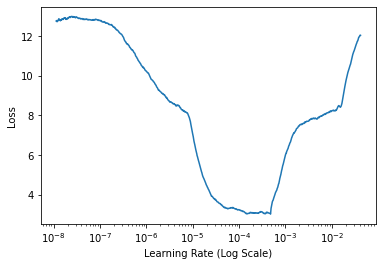

In [0]:
lrf.plot_loss()

In [0]:
MIN_LR = 1e-6
MAX_LR = 1e-4
STEP_SIZE = 2*np.ceil((nsamples/float(batch_size)))
CLR_METHOD = "triangular2"
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=STEP_SIZE)

In [0]:
filepath="models/classifier/"+DS+"/classifier-save-{epoch:02d}-{loss:.3f}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             save_weights_only=False,
                             verbose=1, save_best_only=False, mode='min',
                             period=1)
earlystopping = EarlyStopping(monitor='val_loss',verbose=1,mode='min')
callbacks_list = [checkpoint,clr]#,earlystopping

In [0]:
classifier.compile(optimizer=Adam(MIN_LR),loss='categorical_crossentropy',
                   metrics=['categorical_accuracy',auroc])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
batch_size = 128
num_epochs = 20

In [0]:
train_history = classifier.fit(x = x_train,y = y_train,
                                batch_size = batch_size,
                                epochs=num_epochs,
                                validation_data=[x_val, y_val],
                                callbacks=callbacks_list,verbose=1)

Train on 32046 samples, validate on 3561 samples
Epoch 1/20
32046/32046 [==============================] - 19s 581us/step - loss: 5.7220 - categorical_accuracy: 0.5894 - auroc: 0.8223 - val_loss: 3.1097 - val_categorical_accuracy: 0.7849 - val_auroc: 0.9639

Epoch 00001: saving model to models/classifier/MNIST/classifier-save-01-5.722-3.110.hdf5
Epoch 2/20
32046/32046 [==============================] - 17s 539us/step - loss: 2.9638 - categorical_accuracy: 0.7945 - auroc: 0.9642 - val_loss: 3.0962 - val_categorical_accuracy: 0.7958 - val_auroc: 0.9743

Epoch 00002: saving model to models/classifier/MNIST/classifier-save-02-2.964-3.096.hdf5
Epoch 3/20
32046/32046 [==============================] - 17s 540us/step - loss: 2.8864 - categorical_accuracy: 0.8111 - auroc: 0.9678 - val_loss: 3.0460 - val_categorical_accuracy: 0.8048 - val_auroc: 0.9688

Epoch 00003: saving model to models/classifier/MNIST/classifier-save-03-2.886-3.046.hdf5
Epoch 4/20
32046/32046 [==============================

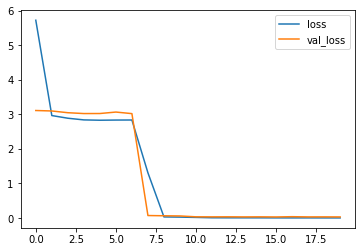

In [0]:
fig = plt.figure()
plt.plot(train_history.history['loss'],label='loss')
plt.plot(train_history.history['val_loss'],label='val_loss')
plt.legend(loc='best')

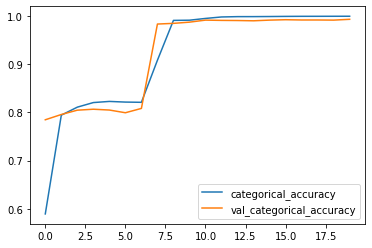

In [0]:
fig = plt.figure()
plt.plot(train_history.history['categorical_accuracy'],label='categorical_accuracy')
plt.plot(train_history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
plt.legend(loc='best')

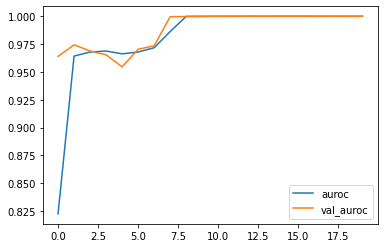

In [0]:
fig = plt.figure()
plt.plot(train_history.history['auroc'],label='auroc')
plt.plot(train_history.history['val_auroc'],label='val_auroc')
plt.legend(loc='best')

In [0]:
y_test_preds = classifier.predict(x_test_known)
print(y_test_preds.shape)

(5877, 6)


In [0]:
roc_auc_score(y_test_known_mapped,y_test_preds,multi_class='ovo')

0.9998860256809505

In [0]:
np.argmax(y_test_preds,axis=1)

array([5, 2, 0, ..., 4, 3, 1])

In [0]:
accuracy_score(y_test_known_mapped,np.argmax(y_test_preds,axis=1))

0.9903011740684022

## Visualize Embeddings

In [17]:
classifier = load_model('models/classifier/MNIST/classifier-save-20-0.002-0.030.hdf5',
                        custom_objects={'GlobalSumPooling2D':GlobalSumPooling2D,
                                        'auroc':auroc})
classifier.summary()











Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_______________________

In [18]:
#encoder = BuildEncoder(in_shape = IMG_SHAPE, latent_dim=LATENT_DIM)
encoder = classifier.layers[1]
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Discriminator_resblock_Down_ (None, 14, 14, 128)       149636    
_________________________________________________________________
Discriminator_resblock_Down_ (None, 7, 7, 128)         312704    
_________________________________________________________________
Discriminator_resblock_1 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
Discriminator_resblock_2 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_sum_pooling2d_1 (Glob (None, 128)               0         
Total para

In [0]:
train_vecs = encoder.predict(x_train)
val_vecs = encoder.predict(x_val)
#test_vecs = encoder.predict(x_test)

In [21]:
print(train_vecs.shape)
print(val_vecs.shape)
#print(test_vecs.shape)

(32046, 128)
(3561, 128)


In [31]:
np.argmax(y_train,axis=1).shape

(32046,)

In [36]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_vecs)

df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df['pca-three'] = pca_result[:,2]
df['y'] = np.argmax(y_train,axis=1)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.5023204  0.16835022 0.08481443]


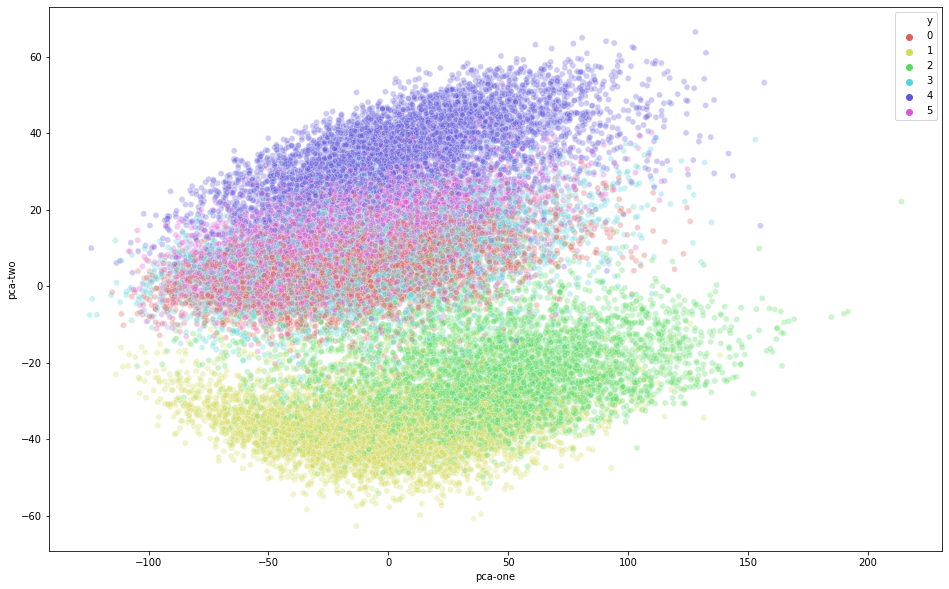

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(known_classes)),
    data=df,
    legend="full",
    alpha=0.3
)

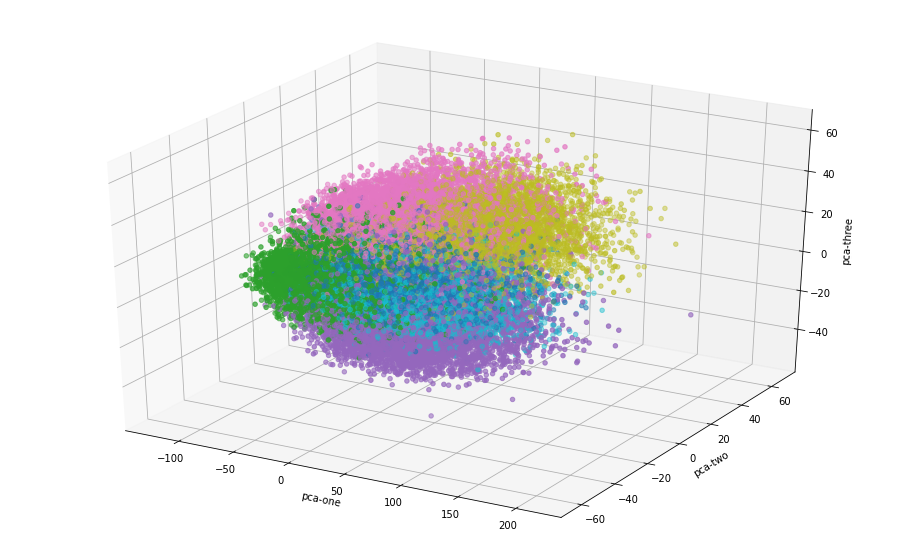

In [42]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"],
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [55]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_vecs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 32046 samples in 0.630s...
[t-SNE] Computed neighbors for 32046 samples in 141.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32046
[t-SNE] Computed conditional probabilities for sample 2000 / 32046
[t-SNE] Computed conditional probabilities for sample 3000 / 32046
[t-SNE] Computed conditional probabilities for sample 4000 / 32046
[t-SNE] Computed conditional probabilities for sample 5000 / 32046
[t-SNE] Computed conditional probabilities for sample 6000 / 32046
[t-SNE] Computed conditional probabilities for sample 7000 / 32046
[t-SNE] Computed conditional probabilities for sample 8000 / 32046
[t-SNE] Computed conditional probabilities for sample 9000 / 32046
[t-SNE] Computed conditional probabilities for sample 10000 / 32046
[t-SNE] Computed conditional probabilities for sample 11000 / 32046
[t-SNE] Computed conditional probabilities for sample 12000 / 32046
[t-SNE] Computed conditional probabilities for 

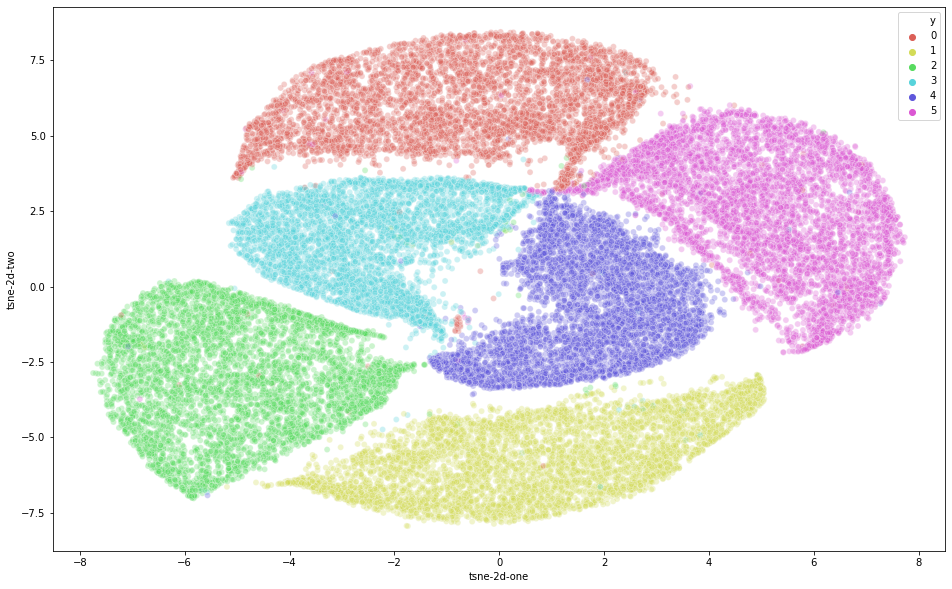

In [57]:
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['y'] = np.argmax(y_train,axis=1)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(known_classes)),
    data=df,
    legend="full",
    alpha=0.3
)

In [58]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_vecs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 32046 samples in 0.631s...
[t-SNE] Computed neighbors for 32046 samples in 142.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32046
[t-SNE] Computed conditional probabilities for sample 2000 / 32046
[t-SNE] Computed conditional probabilities for sample 3000 / 32046
[t-SNE] Computed conditional probabilities for sample 4000 / 32046
[t-SNE] Computed conditional probabilities for sample 5000 / 32046
[t-SNE] Computed conditional probabilities for sample 6000 / 32046
[t-SNE] Computed conditional probabilities for sample 7000 / 32046
[t-SNE] Computed conditional probabilities for sample 8000 / 32046
[t-SNE] Computed conditional probabilities for sample 9000 / 32046
[t-SNE] Computed conditional probabilities for sample 10000 / 32046
[t-SNE] Computed conditional probabilities for sample 11000 / 32046
[t-SNE] Computed conditional probabilities for sample 12000 / 32046
[t-SNE] Computed conditional probabilities for 

In [0]:
df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['tsne-2d-three'] = tsne_results[:,1]
df['y'] = np.argmax(y_train,axis=1)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["tsne-2d-one"], 
    ys=df["tsne-2d-two"], 
    zs=df["tsne-2d-three"], 
    c=df["y"],
    cmap='tab10'
)
ax.set_xlabel('tsne-2d-one')
ax.set_ylabel('tsne-2d-two')
ax.set_zlabel('tsne-2d-three')
plt.show()